In [1]:
from natsort import natsorted
import os
import re
from glob import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import networkx as nx


import imageio
import cv2
import optuna 
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.feature import canny
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from functools import partial
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras import metrics

# caching with sane defaults
from cachier import cachier

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tqdm = partial(tqdm, position=0, leave=True)

In [3]:
# Helper plot functions

def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.show

def plot_all_data(X, y):
    assert X.shape[0] == y.shape[0]
    print(X.shape[0])
    for i in range(X.shape[0]):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
        ax = axes.flatten()
        ax[0].imshow(X[i])
        ax[0].axis("off")
        ax[0].title.set_text(f'{i%(X.shape[0]/3)}')

        ax[1].imshow(y[i], cmap="gray")
        ax[1].axis("off")
        ax[1].title.set_text(f'{i%(X.shape[0]/3)}')
        plt.tight_layout()
        plt.show()

# UNET with VGG16 ImageNet Weights

In [4]:
class Unet:
    
    def __init__(self, input_size):
        self.input_size = input_size
        self.model = self.create_unet_vgg16()
        self.history = None
        
    def conv_block(self, x, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def decoder_block(self, x, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(x)
        x = Concatenate()([x, skip_features])
        x = self.conv_block(x, num_filters)
        return x

    
    def create_unet_vgg16(self):
        """ Input """
        inputs = Input(self.input_size)

        """ Pre-trained VGG16 Model """
        vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

        """ Encoder """
        s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
        s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
        s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
        s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

        """ Bridge """
        b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

        """ Decoder """
        d1 = self.decoder_block(b1, s4, 512)                     ## (64 x 64)
        d2 = self.decoder_block(d1, s3, 256)                     ## (128 x 128)
        d3 = self.decoder_block(d2, s2, 128)                     ## (256 x 256)
        d4 = self.decoder_block(d3, s1, 64)                      ## (512 x 512)

        """ Output """
        outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

        return Model(inputs, outputs, name="VGG16_U-Net")
        
    
    def train(self, X_train, X_val, y_train, y_val, lr=1e-3, batch_size=8, epochs=100):
        self.model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    verbose=1, 
                    epochs=epochs, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
    
    
    def plot_loss(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, 'y', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        
    def plot_accuracy(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)
        plt.plot(epochs, acc, 'y', label='Training acc')
        plt.plot(epochs, val_acc, 'r', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def predict_batch(self, x):
        y = self.model.predict(x)
        y = (y[:,:,:,0] > 0.5).astype(np.uint8)
        return y
    
    def evaluate_model(self, X, y_true):
        y_pred = self.predict_batch(X)
        y_pred = np.squeeze(y_pred)
        y_true = np.squeeze(y_true)
        print(f"Accuracy: {pixel_accuracy(y_true, y_pred)}")
        print(f"Dice: {dice(y_true, y_pred)}")
        print(f"IoU: {iou(y_true, y_pred)}")

## Evaluation Metrics

In [5]:
def dice(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    
    im_sum = y_true.sum() + y_pred.sum()

    # Compute Dice coefficient
    intersection = np.logical_and(y_true, y_pred)

    return 2. * intersection.sum() / im_sum

def pixel_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.uint8).flatten()
    y_pred = np.asarray(y_pred).astype(np.uint8).flatten()
    return accuracy_score(y_true, y_pred)


def iou(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Read in Data

In [6]:
SIZE = (768, 1024)

DATA_PATH_PAIRS = list(
    zip(
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/images-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
        natsorted(
            glob(
                f"puzzle_corners_{SIZE[1]}x{SIZE[0]}/masks-{SIZE[1]}x{SIZE[0]}/*.png"
            )
        ),
    )
)
DATA_IMGS = np.array(
    [
        img_as_float32(imageio.imread(img_path))
        for img_path, _ in tqdm(DATA_PATH_PAIRS, "Loading Images")
    ]
)
DATA_MSKS = np.array(
    [
        img_as_float32(imageio.imread(msk_path))
        for _, msk_path in tqdm(DATA_PATH_PAIRS, "Loading Masks")
    ]
)

SCALE = 0.25
MATCH_IMGS = np.array([
    cv2.resize(img, None, fx=SCALE, fy=SCALE)
    for img in tqdm(DATA_IMGS, "Resizing Images")
])
MATCH_MSKS = np.array([
    np.expand_dims(cv2.resize(img, None, fx=SCALE, fy=SCALE), axis=2)
    for img in tqdm(DATA_MSKS, "Resizing Masks")
])
    
    # Should I be normalizing the data? 
    

Loading Images:   0%|          | 0/48 [00:00<?, ?it/s]

Loading Masks:   0%|          | 0/48 [00:00<?, ?it/s]

Resizing Images:   0%|          | 0/48 [00:00<?, ?it/s]

Resizing Masks:   0%|          | 0/48 [00:00<?, ?it/s]

## Split data

In [22]:
def train_val_test_split(X, y, random_state=42):
    """ Split data into train, validation and test sets"""
   

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=random_state)
    
    print(f"Training images: {X_train.shape[0]}")
    print(f"Validation images: {X_val.shape[0]}")
    print(f"Test images: {X_test.shape[0]}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [25]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(MATCH_IMGS, MATCH_MSKS)

Training images: 32
Validation images: 8
Test images: 8


8


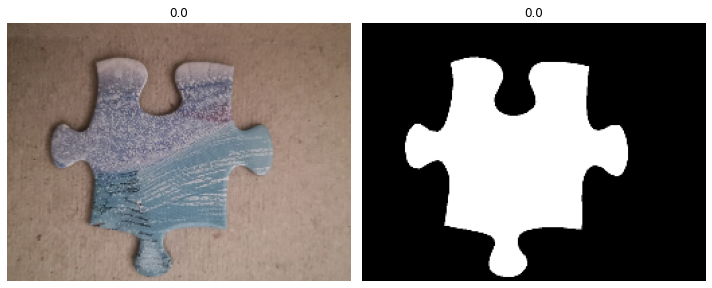

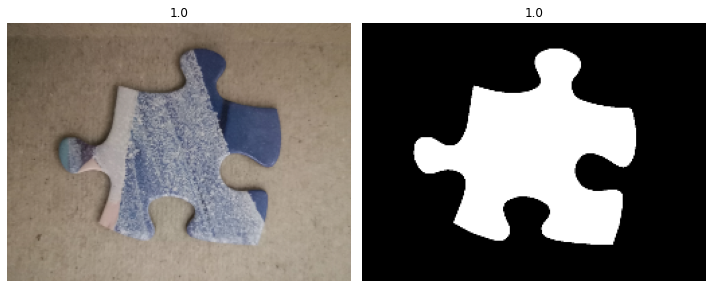

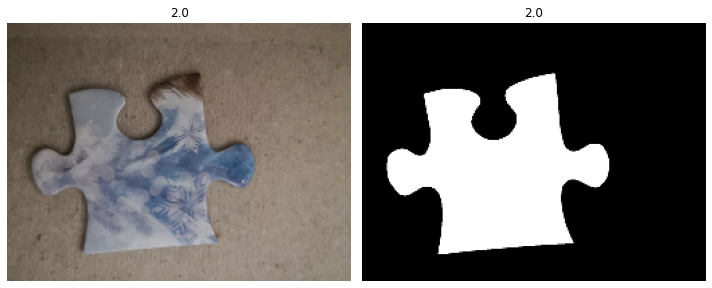

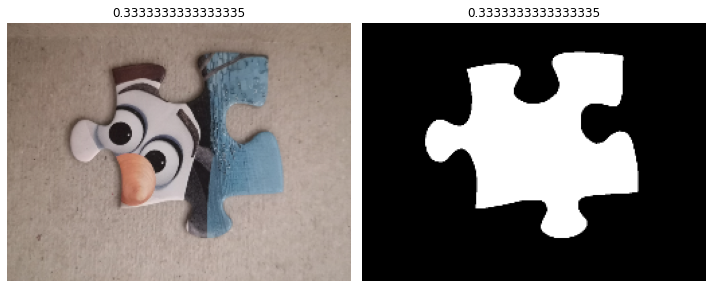

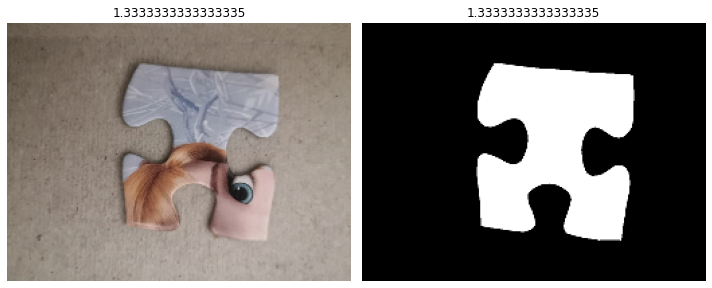

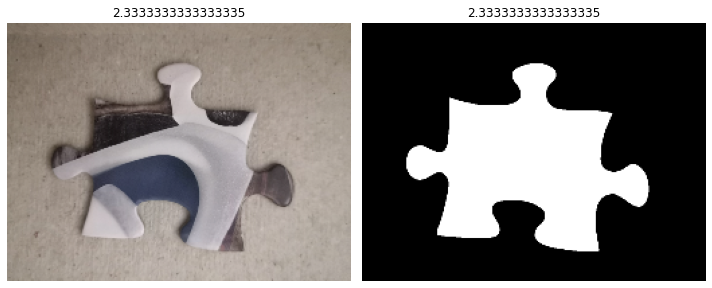

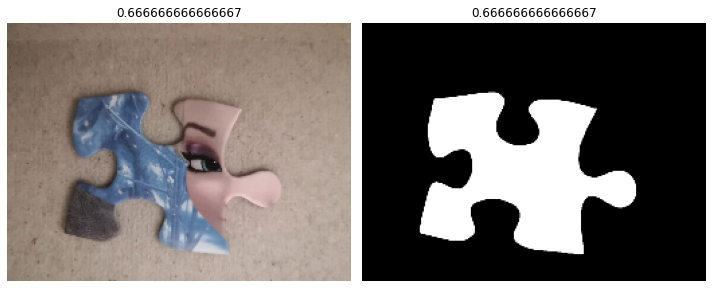

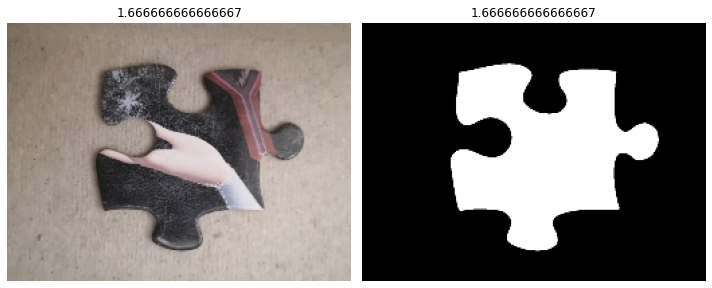

In [26]:
plot_all_data(X_test, y_test)

# Data augmentations

In [9]:
def apply_image_aug(aug_func, X_train, X_val, y_train, y_val, aug_target=True, args={}):
    
    X_train = np.append(X_train, aug_func(X_train[:34], **args).numpy(), 0)
    
    
    X_val = np.append(X_val, aug_func(X_val[:7], **args).numpy(), 0)
    
    
    if aug_target:
        y_train = np.append(y_train, aug_func(y_train[:34], **args).numpy(), 0)
        y_val = np.append(y_val, aug_func(y_val[:7], **args).numpy(), 0)
    else:
        y_train = np.append(y_train, y_train[:34], 0)
        y_val = np.append(y_val, y_val[:7], 0)

    return X_train, X_val, y_train, y_val

def add_data_augmentations(X_train, X_val, y_train, y_val):
    # Spatial augmentations
    
    ## Flipping
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.flip_left_right, X_train, X_val, y_train, y_val)
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.flip_up_down, X_train, X_val, y_train, y_val)    
    
    # ## Rotation
    # X_train, X_val, y_train, y_val = apply_image_aug(tf.image.rot90, X_train, X_val, y_train, y_val)
    
    # Pixel augmentations
    
    ## Brightness
    X_train, X_val, y_train, y_val = apply_image_aug(tf.image.random_brightness, X_train, X_val, y_train, y_val, aug_target=False, args={"max_delta": 0.25})    
    
    ## Contrast
    
    ## Saturation
    
    ## Hue
    
    
    return X_train, X_val, y_train, y_val

# Training model with no data Augmentation

In [10]:
unet = Unet(input_size=X_train[0].shape)

In [11]:
def objective(trial):
    
    model = Unet(input_size=X_train[0].shape).model
    # model.compile(optimizer=Adam(learning_rate=trial.suggest_categorical('lr', [1e-2, 1e-3]), loss='binary_crossentropy', metrics=['accuracy']))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_categorical('lr', [1e-1, 1e-2, 1e-3])), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, 
            batch_size=trial.suggest_categorical('batch_size', [4, 8]), 
            verbose=1, 
            epochs=trial.suggest_categorical('epochs', [50, 100]), 
            validation_data=(X_test, y_test), 
            shuffle=False)
    
    y_pred = model.predict(X_val)
    y_pred = (y_pred[:,:,:,0] > 0.5).astype(np.uint8)
    
    return pixel_accuracy(y_val, y_pred)

In [12]:
study = optuna.create_study(direction='maximize') 

[I 2021-11-11 18:15:29,153] A new study created in memory with name: no-name-60c6f989-7f78-440e-b81d-5224e8b3aaaa


In [13]:
study.optimize(objective, n_trials=12)

Epoch 1/50
9/9 [==============================] - 7s 328ms/step - loss: 0.2573 - accuracy: 0.9105 - val_loss: 283.2295 - val_accuracy: 0.2552
Epoch 2/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1108 - accuracy: 0.9655 - val_loss: 15.7536 - val_accuracy: 0.2553
Epoch 3/50
9/9 [==============================] - 1s 71ms/step - loss: 0.0793 - accuracy: 0.9794 - val_loss: 42.3292 - val_accuracy: 0.2553
Epoch 4/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0629 - accuracy: 0.9835 - val_loss: 54.6076 - val_accuracy: 0.2553
Epoch 5/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0469 - accuracy: 0.9872 - val_loss: 5.6247 - val_accuracy: 0.2605
Epoch 6/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0373 - accuracy: 0.9894 - val_loss: 6.5362 - val_accuracy: 0.2625
Epoch 7/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0301 - accuracy: 0.9915 - val_loss: 3.5689 - val_accuracy: 0.2734
Epoch 8/50
9/9 [=====

[I 2021-11-11 18:16:09,250] Trial 0 finished with value: 0.27732921781994047 and parameters: {'lr': 0.001, 'batch_size': 4, 'epochs': 50}. Best is trial 0 with value: 0.27732921781994047.


Epoch 1/100
9/9 [==============================] - 2s 95ms/step - loss: 0.3028 - accuracy: 0.8774 - val_loss: 18295.8125 - val_accuracy: 0.2552
Epoch 2/100
9/9 [==============================] - 1s 71ms/step - loss: 0.1470 - accuracy: 0.9483 - val_loss: 668.1141 - val_accuracy: 0.2552
Epoch 3/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0983 - accuracy: 0.9635 - val_loss: 452.5100 - val_accuracy: 0.2552
Epoch 4/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0826 - accuracy: 0.9717 - val_loss: 240.4941 - val_accuracy: 0.2552
Epoch 5/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0870 - accuracy: 0.9695 - val_loss: 176.0520 - val_accuracy: 0.2552
Epoch 6/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0868 - accuracy: 0.9689 - val_loss: 90.7191 - val_accuracy: 0.2552
Epoch 7/100
9/9 [==============================] - 1s 73ms/step - loss: 0.1246 - accuracy: 0.9541 - val_loss: 88.5946 - val_accuracy: 0.2553
Epoch 

[I 2021-11-11 18:17:15,737] Trial 1 finished with value: 0.989990234375 and parameters: {'lr': 0.01, 'batch_size': 4, 'epochs': 100}. Best is trial 1 with value: 0.989990234375.


Epoch 1/50
5/5 [==============================] - 4s 160ms/step - loss: 0.5790 - accuracy: 0.7521 - val_loss: 105590.0859 - val_accuracy: 0.2552
Epoch 2/50
5/5 [==============================] - 1s 116ms/step - loss: 0.1902 - accuracy: 0.9367 - val_loss: 3429.7847 - val_accuracy: 0.2552
Epoch 3/50
5/5 [==============================] - 1s 115ms/step - loss: 0.1486 - accuracy: 0.9499 - val_loss: 213.3687 - val_accuracy: 0.2552
Epoch 4/50
5/5 [==============================] - 1s 116ms/step - loss: 0.1241 - accuracy: 0.9516 - val_loss: 54.3920 - val_accuracy: 0.2552
Epoch 5/50
5/5 [==============================] - 1s 115ms/step - loss: 0.1008 - accuracy: 0.9624 - val_loss: 62.2075 - val_accuracy: 0.2552
Epoch 6/50
5/5 [==============================] - 1s 115ms/step - loss: 0.1074 - accuracy: 0.9634 - val_loss: 35.2787 - val_accuracy: 0.2552
Epoch 7/50
5/5 [==============================] - 1s 114ms/step - loss: 0.0958 - accuracy: 0.9665 - val_loss: 36.0263 - val_accuracy: 0.2552
Epoch 

[I 2021-11-11 18:17:48,690] Trial 2 finished with value: 0.9548659551711309 and parameters: {'lr': 0.01, 'batch_size': 8, 'epochs': 50}. Best is trial 1 with value: 0.989990234375.


Epoch 1/50
9/9 [==============================] - 2s 97ms/step - loss: 0.3549 - accuracy: 0.8570 - val_loss: 3721.2964 - val_accuracy: 0.2552
Epoch 2/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1370 - accuracy: 0.9521 - val_loss: 215.9415 - val_accuracy: 0.2552
Epoch 3/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1202 - accuracy: 0.9588 - val_loss: 111.7479 - val_accuracy: 0.2552
Epoch 4/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0965 - accuracy: 0.9659 - val_loss: 142.3781 - val_accuracy: 0.2552
Epoch 5/50
9/9 [==============================] - 1s 72ms/step - loss: 0.0787 - accuracy: 0.9722 - val_loss: 55.7814 - val_accuracy: 0.2552
Epoch 6/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1348 - accuracy: 0.9481 - val_loss: 20.4759 - val_accuracy: 0.1583
Epoch 7/50
9/9 [==============================] - 1s 71ms/step - loss: 0.1028 - accuracy: 0.9623 - val_loss: 20.2932 - val_accuracy: 0.2552
Epoch 8/50
9/9 

[I 2021-11-11 18:18:22,796] Trial 3 finished with value: 0.9065609886532738 and parameters: {'lr': 0.01, 'batch_size': 4, 'epochs': 50}. Best is trial 1 with value: 0.989990234375.


Epoch 1/100
5/5 [==============================] - 2s 160ms/step - loss: 0.4863 - accuracy: 0.8242 - val_loss: 66983.1797 - val_accuracy: 0.2552
Epoch 2/100
5/5 [==============================] - 1s 114ms/step - loss: 0.2343 - accuracy: 0.9183 - val_loss: 2813.8159 - val_accuracy: 0.2552
Epoch 3/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1886 - accuracy: 0.9282 - val_loss: 634.8317 - val_accuracy: 0.2552
Epoch 4/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1735 - accuracy: 0.9393 - val_loss: 249.8226 - val_accuracy: 0.2552
Epoch 5/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1568 - accuracy: 0.9447 - val_loss: 107.6648 - val_accuracy: 0.2552
Epoch 6/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1275 - accuracy: 0.9512 - val_loss: 35.5518 - val_accuracy: 0.2552
Epoch 7/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1164 - accuracy: 0.9569 - val_loss: 32.8661 - val_accuracy: 0.255

[I 2021-11-11 18:19:22,822] Trial 4 finished with value: 0.9541655040922619 and parameters: {'lr': 0.01, 'batch_size': 8, 'epochs': 100}. Best is trial 1 with value: 0.989990234375.


Epoch 1/50
9/9 [==============================] - 2s 95ms/step - loss: 0.2936 - accuracy: 0.8876 - val_loss: 613.3231 - val_accuracy: 0.2552
Epoch 2/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1346 - accuracy: 0.9476 - val_loss: 153.0796 - val_accuracy: 0.2552
Epoch 3/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1194 - accuracy: 0.9565 - val_loss: 93.2696 - val_accuracy: 0.2552
Epoch 4/50
9/9 [==============================] - 1s 71ms/step - loss: 0.1306 - accuracy: 0.9523 - val_loss: 76.2501 - val_accuracy: 0.2552
Epoch 5/50
9/9 [==============================] - 1s 72ms/step - loss: 0.1174 - accuracy: 0.9573 - val_loss: 72.5521 - val_accuracy: 0.2552
Epoch 6/50
9/9 [==============================] - 1s 75ms/step - loss: 0.0868 - accuracy: 0.9680 - val_loss: 33.5469 - val_accuracy: 0.2552
Epoch 7/50
9/9 [==============================] - 1s 73ms/step - loss: 0.0981 - accuracy: 0.9643 - val_loss: 19.6163 - val_accuracy: 0.2553
Epoch 8/50
9/9 [==

[I 2021-11-11 18:19:56,763] Trial 5 finished with value: 0.9776349748883929 and parameters: {'lr': 0.01, 'batch_size': 4, 'epochs': 50}. Best is trial 1 with value: 0.989990234375.


Epoch 1/50
5/5 [==============================] - 2s 161ms/step - loss: 0.4900 - accuracy: 0.7649 - val_loss: 161.5125 - val_accuracy: 0.2553
Epoch 2/50
5/5 [==============================] - 1s 114ms/step - loss: 0.1586 - accuracy: 0.9599 - val_loss: 155.9923 - val_accuracy: 0.2552
Epoch 3/50
5/5 [==============================] - 1s 115ms/step - loss: 0.1080 - accuracy: 0.9762 - val_loss: 235.4967 - val_accuracy: 0.2552
Epoch 4/50
5/5 [==============================] - 1s 115ms/step - loss: 0.0885 - accuracy: 0.9813 - val_loss: 58.8754 - val_accuracy: 0.2552
Epoch 5/50
5/5 [==============================] - 1s 115ms/step - loss: 0.0747 - accuracy: 0.9840 - val_loss: 26.7521 - val_accuracy: 0.2552
Epoch 6/50
5/5 [==============================] - 1s 115ms/step - loss: 0.0616 - accuracy: 0.9869 - val_loss: 14.8098 - val_accuracy: 0.2552
Epoch 7/50
5/5 [==============================] - 1s 115ms/step - loss: 0.0516 - accuracy: 0.9895 - val_loss: 5.7492 - val_accuracy: 0.2554
Epoch 8/50


[I 2021-11-11 18:20:27,735] Trial 6 finished with value: 0.99542236328125 and parameters: {'lr': 0.001, 'batch_size': 8, 'epochs': 50}. Best is trial 6 with value: 0.99542236328125.


Epoch 1/100
9/9 [==============================] - 2s 94ms/step - loss: 0.2702 - accuracy: 0.9030 - val_loss: 151.5160 - val_accuracy: 0.2552
Epoch 2/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0980 - accuracy: 0.9772 - val_loss: 19.8566 - val_accuracy: 0.3282
Epoch 3/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0757 - accuracy: 0.9829 - val_loss: 28.1646 - val_accuracy: 0.2565
Epoch 4/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0555 - accuracy: 0.9878 - val_loss: 6.6141 - val_accuracy: 0.2669
Epoch 5/100
9/9 [==============================] - 1s 72ms/step - loss: 0.0436 - accuracy: 0.9902 - val_loss: 0.5931 - val_accuracy: 0.6497
Epoch 6/100
9/9 [==============================] - 1s 75ms/step - loss: 0.0386 - accuracy: 0.9905 - val_loss: 1.9250 - val_accuracy: 0.2723
Epoch 7/100
9/9 [==============================] - 1s 73ms/step - loss: 0.0355 - accuracy: 0.9906 - val_loss: 0.7892 - val_accuracy: 0.7203
Epoch 8/100
9/9 

[I 2021-11-11 18:21:34,157] Trial 7 finished with value: 0.5155465262276786 and parameters: {'lr': 0.001, 'batch_size': 4, 'epochs': 100}. Best is trial 6 with value: 0.99542236328125.


Epoch 1/100
5/5 [==============================] - 2s 169ms/step - loss: 0.6128 - accuracy: 0.7941 - val_loss: 87260.2344 - val_accuracy: 0.2552
Epoch 2/100
5/5 [==============================] - 1s 114ms/step - loss: 0.2245 - accuracy: 0.9178 - val_loss: 2580.7212 - val_accuracy: 0.2552
Epoch 3/100
5/5 [==============================] - 1s 114ms/step - loss: 0.2154 - accuracy: 0.9227 - val_loss: 215.4876 - val_accuracy: 0.2552
Epoch 4/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1839 - accuracy: 0.9352 - val_loss: 142.0624 - val_accuracy: 0.2552
Epoch 5/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1723 - accuracy: 0.9414 - val_loss: 69.2336 - val_accuracy: 0.2552
Epoch 6/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1472 - accuracy: 0.9463 - val_loss: 17.9392 - val_accuracy: 0.2552
Epoch 7/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1374 - accuracy: 0.9508 - val_loss: 20.7110 - val_accuracy: 0.2553

[I 2021-11-11 18:22:35,964] Trial 8 finished with value: 0.8907935732886905 and parameters: {'lr': 0.01, 'batch_size': 8, 'epochs': 100}. Best is trial 6 with value: 0.99542236328125.


Epoch 1/100
5/5 [==============================] - 2s 160ms/step - loss: 0.5190 - accuracy: 0.8341 - val_loss: 877637.3125 - val_accuracy: 0.2552
Epoch 2/100
5/5 [==============================] - 1s 117ms/step - loss: 0.1902 - accuracy: 0.9373 - val_loss: 18735.5273 - val_accuracy: 0.2552
Epoch 3/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1694 - accuracy: 0.9419 - val_loss: 2146.1748 - val_accuracy: 0.2552
Epoch 4/100
5/5 [==============================] - 1s 114ms/step - loss: 0.1647 - accuracy: 0.9420 - val_loss: 949.4654 - val_accuracy: 0.2552
Epoch 5/100
5/5 [==============================] - 1s 117ms/step - loss: 0.1393 - accuracy: 0.9519 - val_loss: 266.1541 - val_accuracy: 0.2552
Epoch 6/100
5/5 [==============================] - 1s 115ms/step - loss: 0.1191 - accuracy: 0.9567 - val_loss: 277.6648 - val_accuracy: 0.2552
Epoch 7/100
5/5 [==============================] - 1s 116ms/step - loss: 0.1122 - accuracy: 0.9621 - val_loss: 199.5373 - val_accuracy: 

[I 2021-11-11 18:23:35,846] Trial 9 finished with value: 0.8903837658110119 and parameters: {'lr': 0.01, 'batch_size': 8, 'epochs': 100}. Best is trial 6 with value: 0.99542236328125.


Epoch 1/50
5/5 [==============================] - 2s 158ms/step - loss: 0.9594 - accuracy: 0.6042 - val_loss: 83670.4375 - val_accuracy: 0.7408
Epoch 2/50
5/5 [==============================] - 1s 112ms/step - loss: 0.5521 - accuracy: 0.7613 - val_loss: 12472.9482 - val_accuracy: 0.2552
Epoch 3/50
5/5 [==============================] - 1s 113ms/step - loss: 0.4802 - accuracy: 0.7973 - val_loss: 5207.6924 - val_accuracy: 0.2552
Epoch 4/50
5/5 [==============================] - 1s 113ms/step - loss: 0.4532 - accuracy: 0.8118 - val_loss: 2068.2856 - val_accuracy: 0.2552
Epoch 5/50
5/5 [==============================] - 1s 113ms/step - loss: 0.4370 - accuracy: 0.8172 - val_loss: 1121.3654 - val_accuracy: 0.2552
Epoch 6/50
5/5 [==============================] - 1s 113ms/step - loss: 0.3969 - accuracy: 0.8339 - val_loss: 701.2586 - val_accuracy: 0.2552
Epoch 7/50
5/5 [==============================] - 1s 114ms/step - loss: 0.3149 - accuracy: 0.8800 - val_loss: 357.1216 - val_accuracy: 0.2552

[I 2021-11-11 18:24:06,237] Trial 10 finished with value: 0.8223906017485119 and parameters: {'lr': 0.1, 'batch_size': 8, 'epochs': 50}. Best is trial 6 with value: 0.99542236328125.


Epoch 1/100
9/9 [==============================] - 2s 119ms/step - loss: 0.2649 - accuracy: 0.8960 - val_loss: 190.9889 - val_accuracy: 0.2552
Epoch 2/100
9/9 [==============================] - 1s 70ms/step - loss: 0.0941 - accuracy: 0.9713 - val_loss: 158.0892 - val_accuracy: 0.2552
Epoch 3/100
9/9 [==============================] - 1s 71ms/step - loss: 0.0763 - accuracy: 0.9772 - val_loss: 99.8550 - val_accuracy: 0.2552
Epoch 4/100
9/9 [==============================] - 1s 71ms/step - loss: 0.0579 - accuracy: 0.9825 - val_loss: 24.8894 - val_accuracy: 0.2553
Epoch 5/100
9/9 [==============================] - 1s 71ms/step - loss: 0.0431 - accuracy: 0.9874 - val_loss: 12.5874 - val_accuracy: 0.2558
Epoch 6/100
9/9 [==============================] - 1s 71ms/step - loss: 0.0334 - accuracy: 0.9897 - val_loss: 3.8737 - val_accuracy: 0.2637
Epoch 7/100
9/9 [==============================] - 1s 71ms/step - loss: 0.0281 - accuracy: 0.9910 - val_loss: 2.6313 - val_accuracy: 0.2922
Epoch 8/100


[I 2021-11-11 18:25:11,753] Trial 11 finished with value: 0.9952101934523809 and parameters: {'lr': 0.001, 'batch_size': 4, 'epochs': 100}. Best is trial 6 with value: 0.99542236328125.


In [14]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 12
Best trial:
  Value: 0.99542236328125
  Params: 
    lr: 0.001
    batch_size: 8
    epochs: 50


In [15]:
print(study.best_trial.value)

0.99542236328125


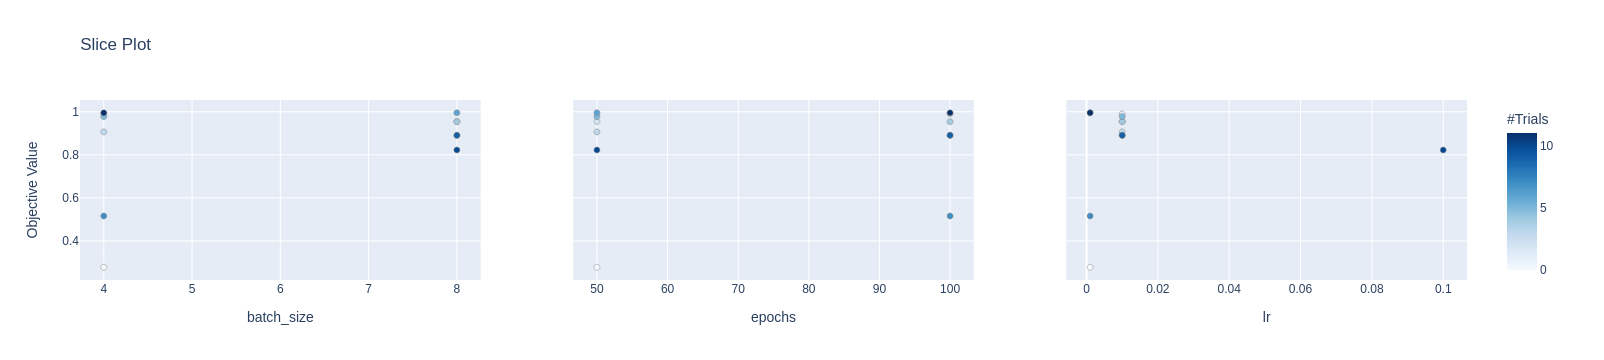

In [16]:
optuna.visualization.plot_slice(study)

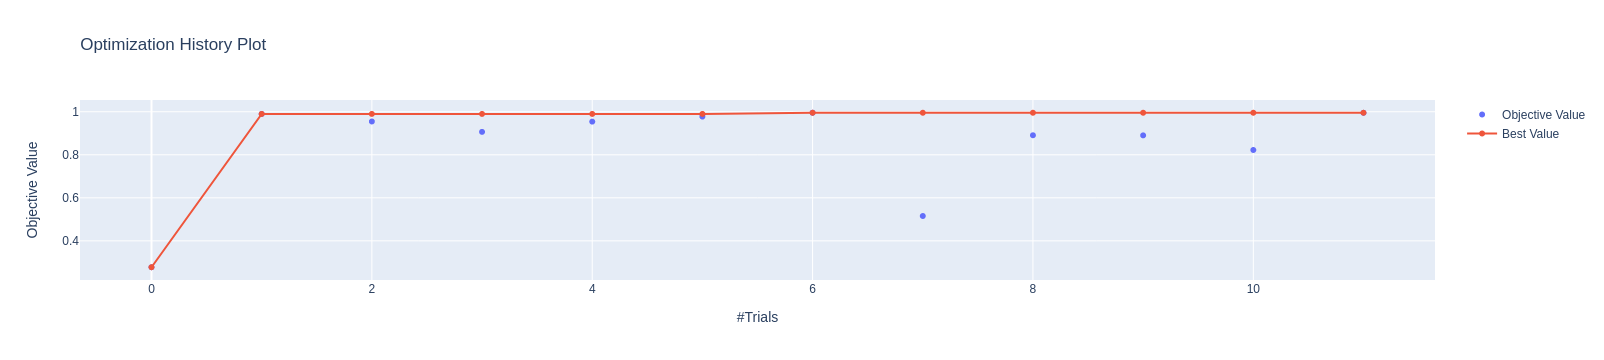

In [17]:
optuna.visualization.plot_optimization_history(study)

In [18]:
print(asdfsdf)

NameError: name 'asdfsdf' is not defined

In [ ]:
unet.train(X_train, X_val, y_train, y_val, lr=1e-3, batch_size=16, epochs=100)

In [ ]:
unet.plot_loss()

In [ ]:
unet.plot_accuracy()

In [ ]:
unet.evaluate_model(X_test, y_test)

In [ ]:
unet.evaluate_model(X_train, y_train)

In [ ]:
unet.evaluate_model(X_val, y_val)

# Training model with data Augmentation

In [19]:
X_train, X_val, y_train, y_val = add_data_augmentations(X_train, X_val, y_train, y_val)
print(f"Training images: {X_train.shape[0]}")
print(f"Validation images: {X_val.shape[0]}")
print(f"Test images: {X_test.shape[0]}")

Training images: 136
Validation images: 28
Test images: 7


In [25]:
study = optuna.create_study(direction='maximize') 

[I 2021-11-11 19:51:29,666] A new study created in memory with name: no-name-24ab5a84-7581-473d-a4d3-9a80eb40c8bb


In [26]:
def objective(trial):
    
    model = Unet(input_size=X_train[0].shape).model
    # model.compile(optimizer=Adam(learning_rate=trial.suggest_categorical('lr', [1e-2, 1e-3]), loss='binary_crossentropy', metrics=['accuracy']))
    model.compile(optimizer=Adam(learning_rate=trial.suggest_categorical('lr', [1e-1, 1e-2, 1e-3])), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, 
            batch_size=trial.suggest_categorical('batch_size', [4, 8]), 
            verbose=1, 
            epochs=trial.suggest_categorical('epochs', [50, 100]), 
            validation_data=(X_test, y_test), 
            shuffle=False)
    
    y_pred = model.predict(X_val)
    y_pred = (y_pred[:,:,:,0] > 0.5).astype(np.uint8)
    
    return pixel_accuracy(y_val, y_pred)
    


In [ ]:
study.optimize(objective, n_trials=12)

Epoch 1/100
34/34 [==============================] - 4s 76ms/step - loss: 0.1777 - accuracy: 0.9300 - val_loss: 134.5184 - val_accuracy: 0.2552
Epoch 2/100
34/34 [==============================] - 2s 69ms/step - loss: 0.0881 - accuracy: 0.9684 - val_loss: 15.5034 - val_accuracy: 0.2552
Epoch 3/100
34/34 [==============================] - 2s 69ms/step - loss: 0.0758 - accuracy: 0.9708 - val_loss: 2.4820 - val_accuracy: 0.2720
Epoch 4/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0733 - accuracy: 0.9707 - val_loss: 11.1688 - val_accuracy: 0.2573
Epoch 5/100
34/34 [==============================] - 2s 69ms/step - loss: 0.0661 - accuracy: 0.9737 - val_loss: 0.6582 - val_accuracy: 0.7189
Epoch 6/100
34/34 [==============================] - 2s 69ms/step - loss: 0.0568 - accuracy: 0.9769 - val_loss: 2.8200 - val_accuracy: 0.2748
Epoch 7/100
34/34 [==============================] - 2s 69ms/step - loss: 0.0451 - accuracy: 0.9809 - val_loss: 1.0007 - val_accuracy: 0.5361
Ep

[I 2021-11-11 19:55:28,808] Trial 0 finished with value: 0.5962749662853423 and parameters: {'lr': 0.01, 'batch_size': 4, 'epochs': 100}. Best is trial 0 with value: 0.5962749662853423.


Epoch 1/100
17/17 [==============================] - 3s 136ms/step - loss: 0.1945 - accuracy: 0.9281 - val_loss: 35.6313 - val_accuracy: 0.2552
Epoch 2/100
17/17 [==============================] - 2s 126ms/step - loss: 0.0631 - accuracy: 0.9830 - val_loss: 358.0675 - val_accuracy: 0.2554
Epoch 3/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0427 - accuracy: 0.9880 - val_loss: 8.7891 - val_accuracy: 0.3785
Epoch 4/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0307 - accuracy: 0.9907 - val_loss: 45.4247 - val_accuracy: 0.2681
Epoch 5/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0256 - accuracy: 0.9916 - val_loss: 0.3443 - val_accuracy: 0.9027
Epoch 6/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0212 - accuracy: 0.9924 - val_loss: 0.2204 - val_accuracy: 0.9361
Epoch 7/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0184 - accuracy: 0.9929 - val_loss: 0.3178 - val_accuracy: 0.

[I 2021-11-11 19:59:02,638] Trial 1 finished with value: 0.8613659086681548 and parameters: {'lr': 0.001, 'batch_size': 8, 'epochs': 100}. Best is trial 1 with value: 0.8613659086681548.


Epoch 1/100
34/34 [==============================] - 3s 77ms/step - loss: 0.1934 - accuracy: 0.9259 - val_loss: 306.2189 - val_accuracy: 0.2552
Epoch 2/100
34/34 [==============================] - 2s 70ms/step - loss: 0.1038 - accuracy: 0.9605 - val_loss: 116.1816 - val_accuracy: 0.2552
Epoch 3/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0945 - accuracy: 0.9627 - val_loss: 13.4448 - val_accuracy: 0.2583
Epoch 4/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0617 - accuracy: 0.9762 - val_loss: 6.7329 - val_accuracy: 0.3011
Epoch 5/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0624 - accuracy: 0.9755 - val_loss: 1.9222 - val_accuracy: 0.3284
Epoch 6/100
34/34 [==============================] - 2s 69ms/step - loss: 0.0568 - accuracy: 0.9772 - val_loss: 0.5451 - val_accuracy: 0.7406
Epoch 7/100
34/34 [==============================] - 2s 70ms/step - loss: 0.0486 - accuracy: 0.9794 - val_loss: 0.3542 - val_accuracy: 0.8471
E

[I 2021-11-11 20:03:01,540] Trial 2 finished with value: 0.9593019031343006 and parameters: {'lr': 0.01, 'batch_size': 4, 'epochs': 100}. Best is trial 2 with value: 0.9593019031343006.


Epoch 1/50


In [22]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 24
Best trial:
  Value: 0.9957609630766369
  Params: 
    lr: 0.001
    batch_size: 8
    epochs: 100


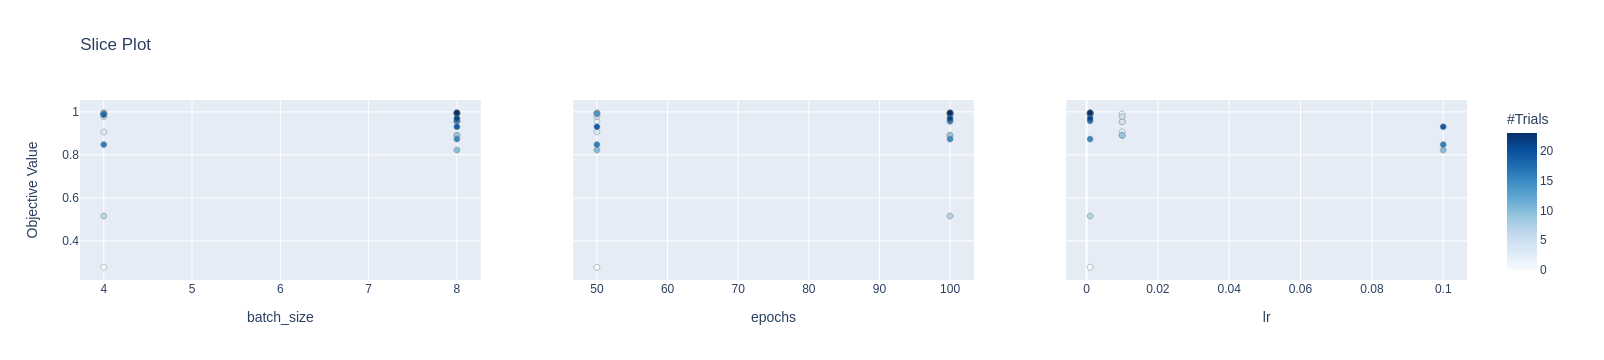

In [23]:
optuna.visualization.plot_slice(study)

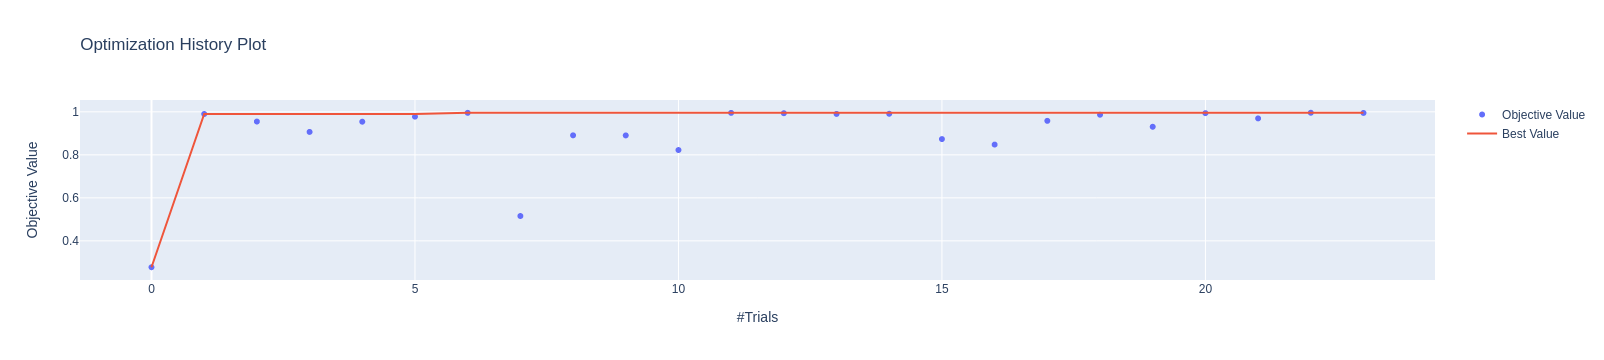

In [24]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
unet = Unet(input_size=X_train[0].shape)

In [ ]:
unet.train(X_train, X_val, y_train, y_val, lr=1e-3, batch_size=16, epochs=100)

In [ ]:
unet.plot_loss()

In [ ]:
unet.plot_accuracy()

In [ ]:
unet.evaluate_model(X_test, y_test)

In [ ]:
unet.evaluate_model(X_train, y_train)

In [ ]:
unet.evaluate_model(X_val, y_val)

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(unet.predict_batch(X_test), y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
from tensorflow.keras.metrics import IoU

In [ ]:
from tensorflow.keras.metrics import Accuracy
acc_keras = Accuracy()  
acc_keras.update_state(unet.predict_batch(X_test), y_test)
print("Acc =", IOU_keras.result().numpy())

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
temp = KerasClassifier(unet.model)

In [ ]:
import keras_tuner as kt

In [ ]:
unet = Unet(input_size=X_train[0].shape)